## Data preprocessing

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# import rpy2.robjects as robjects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pyreadr
import os
from PIL import Image


### Convert RBG into Grayscale

In [3]:
# def rgb2gray(Chrr):
#     snp = np.load(f"../../SNPimg/Chr{Chrr}_tsne_277.npy")
#     snp_gray = snp[:,:,:,0]
#     print(snp_gray.shape)
#     np.save(f'../../SNPimg/Chr{Chrr}_tsne_277.npy', snp_gray)

# for Chrr in range(1,13):
#     rgb2gray(Chrr)

(array([[  1.,   0.,   0., ...,   0.,   0., 276.],
        [  3.,   0.,   0., ...,   0.,   0., 274.],
        [ 10.,   0.,   0., ...,   0.,   0., 267.],
        ...,
        [  0.,   0.,   0., ...,   4.,   0., 272.],
        [  0.,   0.,   0., ...,   0.,   0., 277.],
        [  0.,   0.,   0., ...,   1.,   0., 276.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 277 BarContainer objects>)

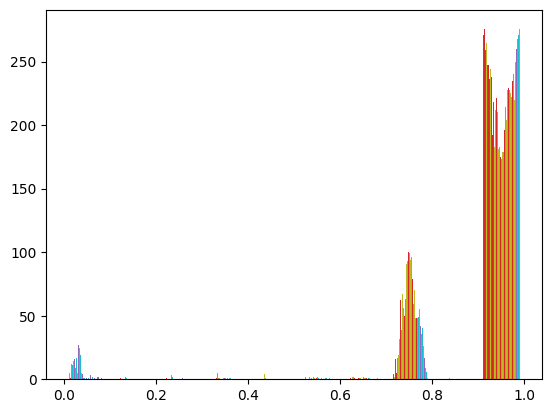

In [4]:
temp = np.load(f"../../SNPimg/Chr1_tsne_277.npy")
plt.hist(temp[0,:,:])

In [5]:
# load all the SNP images from each chromosome.
snp_images = [np.load(f"../../SNPimg/Chr{Chrr}_tsne_277.npy").reshape(162,277,277) for Chrr in range(1,13)]
snp_images_array = np.array(snp_images)

In [6]:
chrr = str(1)
result = pyreadr.read_r('../../Geno/SNPchrs/SNPchr'+ chrr+ '.RData')
geno_chr = result["geno_chr"]
expr = geno_chr
y = expr.index

In [ ]:
# for id in range(162):
#     ## Create folders to save reorganized snp images.
#     id_str = y[id]
#     id_path = "../../SNPimg/dataset/" + id_str 
#     if os.path.exists(id_path):
#         print("Already this, go to next \n")
#     else: os.system("mkdir -p " + id_path)

#     ## Save images
#     snp_ind = snp_images_array[:,id,:,:]
#     for chrr in range(12):
#         snp_chr = snp_ind[chrr,:,:]
#         # print(snp_chr.shape)
#         snp_chr = np.repeat(snp_chr.reshape([277,277,1]), 3, axis=2)
#         plt.imsave(f"{id_path}/Chr{chrr+1}_snp_images.png", snp_chr)
#         print("Saved! \n")


In [ ]:
temp = np.load("../../SNPimg/dataset/NSFTV_1/Chr1_snp_images.np.npy")
print(temp.shape)
plt.imshow(temp, cmap = 'gray')
plt.axis('on')
plt.title("Id: " + y[0])
plt.show()

## CNN ----- Multiple channels for chromosomes

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Flatten
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow import keras
import random
import tensorflow as tf
from scipy.stats import zscore
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import load_model
from keras.callbacks import CSVLogger

In [ ]:
import os
metL = []
for i in range(1, 31):
    metL.append(pd.read_csv('../../Met/CrossValidation/cv_' + str(i) + '/met_cv_' + str(i) + '.csv'))
    

In [ ]:
def met_read(met_cv1, mett):
    
    # met_cv1 = metL[0]
    # met_cv1 = pd.read_csv('../Met/CrossValidation/cv_1/met_cv_1.csv')
    met_cv1_train = met_cv1.query("Treatment=='Control' and set == 'train'")
    met_cv1_test = met_cv1.query("Treatment=='Control' and set == 'test'")

    train_ix = met_cv1_train.index.tolist()
    test_ix = met_cv1_test.index.tolist()

    X = snp_images_multi_channels
    X_train = X[train_ix]
    X_test = X[test_ix]


    Y_train_unscale = np.array(met_cv1_train.iloc[:,mett+1])
    Y_train = zscore(Y_train_unscale)

    Mean_tr = np.mean(Y_train_unscale)
    SD_tr = np.std(Y_train_unscale)                                                

    Y_test_unscale = np.array(met_cv1_test.iloc[:,mett+1])
    Y_test = (Y_test_unscale - Mean_tr)/SD_tr



    #remove Treatment, set columns 
                                                #just keep metabolie a1
    # print('X_train shape is:', X_train.shape)
    # print('X_test shape is:', X_test.shape)
    # print('Y_train shape is:', Y_train.shape)
    # print('Y_test shape is:', Y_test.shape)

    return X_train, X_test, Y_train, Y_test

In [ ]:
from keras.callbacks import CSVLogger

# Create a simple Keras model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Define the CSVLogger callback
csv_logger = CSVLogger('training.log')

# Train the model while using the CSVLogger callback
model.fit(X_train, y_train, epochs=10, callbacks=[csv_logger])


In [ ]:
def cnn_train(X_train, X_test, Y_train, Y_test, seed):
    
    seed=seed

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)


    model = Sequential()

    # Add a convolutional layer
    model.add(Conv2D(36, (3, 3), input_shape=(277, 277, 12), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(36*2, (3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # model.add(Conv2D(36*3, (3, 3), activation='relu', padding = 'same'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.5))
    # model.add(BatchNormalization())

    model.add(Conv2D(36*2, (3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-5)
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    # print(model.summary())
    es = EarlyStopping(monitor='val_loss', patience=10)
    csv_logger = CSVLogger('training.log')
    # mc = ModelCheckpoint('../best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history=model.fit(X_train, Y_train, 
                    batch_size = 100,
                    epochs = 30,
                    verbose = 1,
                    validation_data = (X_test, Y_test),
                    callbacks = [es, csv_logger])
    
    # best_model = load_model('../best_model.h5')                

    Y_pred = model.predict(X_test, verbose = 0).reshape(38)
    corr = np.corrcoef(Y_test, Y_pred)[0,1]

    # print("MSE:", mean_squared_error(Y_test, Y_pred))
    print("Corr:", np.corrcoef(Y_test, Y_pred)[0,1])

    return model, history, corr

In [ ]:
import sys
oldStdout = sys.stdout
file = open('logFile', 'w')
sys.stdout = file

In [ ]:
corr_cnn = list()

for cvv in range(0, 1):

    print(f'Now is running cv # {cvv+1}')
    X_train, X_test, Y_train, Y_test = met_read(metL[cvv], mett=4)
    _, cnnn_history, corr_single = cnn_train(X_train, X_test, Y_train, Y_test, seed = 1)
    sys.stdout = oldStdout
    corr_cnn.append(corr_single)
    # cnnn_model.save(f"../outputs/cv{cvv+1}_model.h5")
    print("###########################################")


In [ ]:
plt.plot(cnnn_history.history['loss'], label='loss')
plt.plot(cnnn_history.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# from keras.models import load_model
# cv1 = load_model("../outputs/cv1_model.h5")

# Y_pred = cv1.predict(X_test).reshape(38)

# print("MSE:", mean_squared_error(Y_test, Y_pred))
# print("Corr:", np.corrcoef(Y_test, Y_pred)[0,1])

In [ ]:
# Generate some example data
# data = np.random.randn(100, 4)  # 100 data points in 4 groups
gblup = np.loadtxt("../gblup_25cv_met4.txt").reshape(25,1)
dl = np.loadtxt("../DL4GP_25cv_met4.txt").reshape(25,1)
# dl1 = np.loadtxt("../DL4GP_25cv_300epoch.txt").reshape(25,1)

temp = np.concatenate([gblup, dl], axis = 1)

# Create a boxplot
plt.boxplot(temp)

# Add labels and title
# plt.xticks([1, 2, 3, 4], ['Group 1', 'Group 2', 'Group 3', 'Group 4'])
plt.xticks([1, 2], ['GBLUP', 'CNN100'])
plt.xlabel('Models')
plt.ylabel('Predictive correlation')
plt.title('Boxplot met4')

# Show the plot
plt.show()

## MLP

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.backend import dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def MLP(X_train, X_test, Y_train, Y_test):

    seed=42

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential(
            [
                Dense(1024, input_shape=(X_train.shape[1],), activation="relu", name = "layer1"),
                Dropout(0.2),
                Dense(512, activation="relu", name = "layer2"),
                Dropout(0.2),
                Dense(512, activation="relu", name = "layer3"),
                Dropout(0.2),
                Dense(1024, activation="relu", name = "layer"),
                Dropout(0.2),
                Dense(1, activation="linear", name = "layer4")
            ]
        )

    # print(model.summary())
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-5)
    model.compile(loss='mse',
                    optimizer=opt,
                    metrics=['mse'])

    nb_epoch = 1000
    batch_size = 50
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=50)

    history = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            verbose=0,
            validation_data=(X_test, Y_test),
            callbacks=[early_stopping])

    Y_pred = model.predict(X_test).reshape(38)

    print("MSE:", mean_squared_error(Y_test, Y_pred))
    print("Corr:", np.corrcoef(Y_test, Y_pred)[0,1])

    print('############################ \n')
    return history

In [ ]:
for i in range(0, 11):
    print("NOW is running cv #", i+1)
    X_train, X_test, Y_train, Y_test = met_read(metL[i])
    history = MLP(X_train, X_test, Y_train, Y_test)

In [ ]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend(loc='upper right')



## CNN
https://stackoverflow.com/questions/66220774/difference-between-the-input-shape-for-a-1d-cnn-2d-cnn-and-3d-cnn  
https://www.datatechnotes.com/2019/12/how-to-fit-regression-data-with-cnn.html

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D, MaxPool1D
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf

In [ ]:
def CNN(X_train, X_test, Y_train, Y_test):

    seed=42

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(Conv1D(32, 8, activation="relu", input_shape=(193,1), padding='same'))
    model.add(Conv1D(64, 4, activation="relu", padding='same'))
    # model.add(Conv1D(128, 8, activation="relu"))
    # model.add(Conv1D(512, 8, activation="relu"))
    # model.add(Conv1D(32, 8, activation="relu"))
    # model.add(MaxPool1D())
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-5)
    model.compile(loss="mse", optimizer=opt, metrics=['mse'])
    model.summary()
    early_stopping = EarlyStopping(monitor='val_loss', patience=50)

    history_cnn = model.fit(X_train, Y_train, 
                            batch_size=12,
                            epochs=200, 
                            verbose=0,
                            validation_data=(X_test, Y_test),
                            callbacks=[early_stopping])

    Y_pred = model.predict(X_test).reshape(38)

    print("MSE:", mean_squared_error(Y_test, Y_pred))
    print("Corr:", np.corrcoef(Y_test, Y_pred)[0,1])


    print('############################ \n')
    
    return history_cnn

In [ ]:
for i in range(0, 1):
    print("NOW is running cv #", i+1)
    X_train, X_test, Y_train, Y_test = met_read(metL[i])
    history_cnn = CNN(X_train, X_test, Y_train, Y_test)

In [ ]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend(loc='upper right')


In [ ]:
X_train.shape #155*193 

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

In [ ]:
fe = KernelPCA(n_components=2,
               kernel = 'rbf', 
               n_jobs=10, 
               random_state=42)

In [ ]:
X_train[0, :]

In [ ]:
X_new = fe.fit_transform(X_train[0, :].T)

In [ ]:
X_new.shape